Dataset from [Kaggle](https://www.kaggle.com/competitions/dogs-vs-cats/data?select=train.zip)

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

In [2]:
# Set up the plot style
sns.set_theme(style="whitegrid")

# Load the model

In [3]:
# Load the DINO model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')
model = model.to(device)
model.eval()
print(f"Model loaded at device {device}")

Using cache found in /home/maparla/.cache/torch/hub/facebookresearch_dino_main


Model loaded at device cuda


In [4]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Load the dataset

In [5]:
# Custom Dataset
class CatsDogDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.images = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.folder_path, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = 0 if img_name.startswith('cat') else 1
        return image, label, img_name

In [6]:
# Create dataset and dataloader
DATASET_PATH = '/home/maparla/Desktop/catsNdogs'
dataset = CatsDogDataset(DATASET_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
print(f"Dataset loaded with {len(dataset)} images")

Dataset loaded with 25000 images


# Extract features

In [7]:
features = []
labels = []
image_names = []

with torch.no_grad():
    for batch, label, names in tqdm(dataloader):
        output = model(batch.to(device))
        features.append(output.cpu().numpy())
        labels.extend(label.cpu().numpy())
        image_names.extend(names)

  0%|          | 0/1563 [00:00<?, ?it/s]

In [8]:
# Group features
features = np.concatenate(features)
features.shape

(25000, 384)

# Perform t-SNE

In [9]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

In [10]:
features_tsne.shape

(25000, 2)

In [11]:
# After feature extraction and t-SNE, create a DataFrame for easier plotting
df_tsne = pd.DataFrame({
    'tsne_1': features_tsne[:, 0], 'tsne_2': features_tsne[:, 1],
    'label': labels, 'image_name': image_names
})

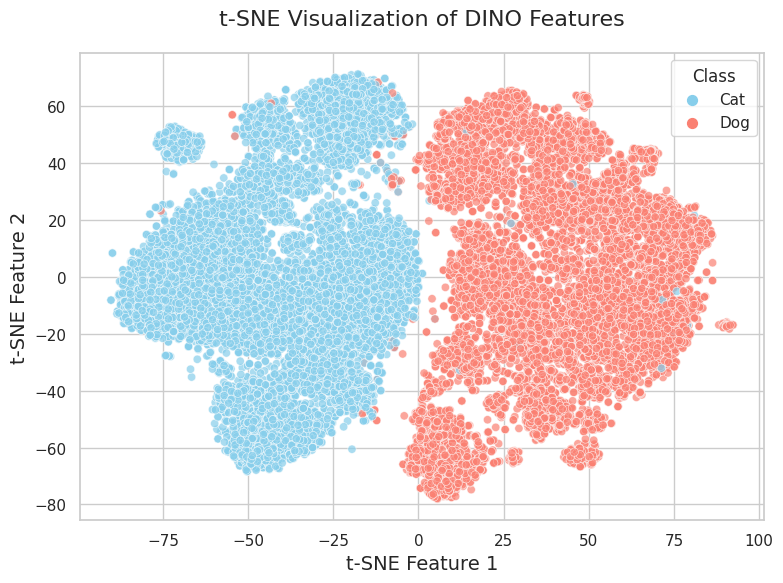

In [21]:
plt.figure(figsize=(8, 6))

# Create the main scatter plot
scatter = sns.scatterplot(
    data=df_tsne,
    x='tsne_1', y='tsne_2',
    hue='label',
    palette={0: 'skyblue', 1: 'salmon'},
    legend='full',
    alpha=0.7
)

# Customize the legend
legend_labels = ['Cat', 'Dog']
# Create a custom legend with markers (dots)
legend_elements = [
    plt.scatter([], [], c='skyblue', alpha=1, s=50, label='Cat'),
    plt.scatter([], [], c='salmon', alpha=1, s=50, label='Dog')
]
plt.legend(handles=legend_elements, title='Class', loc='best')

# Set title and labels
plt.title('t-SNE Visualization of DINO Features', fontsize=16, pad=20)
plt.xlabel('t-SNE Feature 1', fontsize=14)
plt.ylabel('t-SNE Feature 2', fontsize=14)

# Improve the layout
plt.tight_layout()

plt.savefig('t-SNE.png', dpi=300, transparent=True)

# Show the plot
plt.show()

# KNN: Nearest Neighbors

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

In [14]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val, names_train, names_val = train_test_split(
    features, labels, image_names, test_size=0.2, random_state=42, stratify=labels
)

In [15]:
# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [16]:
# Make predictions on the validation set
y_pred = knn.predict(X_val)

# Calculate and print the accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9974


In [17]:
# Create a DataFrame with the results
results_df = pd.DataFrame({
    'image_name': names_val,
    'ground_truth': y_val,
    'prediction': y_pred
})
results_df.head()

,image_name,ground_truth,prediction
0,dog.427.jpg,1,1
1,dog.4104.jpg,1,1
2,cat.6721.jpg,0,0
3,cat.12301.jpg,0,0
4,dog.12262.jpg,1,1


In [18]:
# Identify misclassified cases
misclassified = results_df[results_df['ground_truth'] != results_df['prediction']]

# Separate misclassified cats and dogs
misclassified_cats = misclassified[misclassified['ground_truth'] == 0]
misclassified_dogs = misclassified[misclassified['ground_truth'] == 1]

# Print some statistics
print(f"Total misclassified: {len(misclassified)} out of {len(results_df)}")
print(f"Misclassified cats: {len(misclassified_cats)}")
print(f"Misclassified dogs: {len(misclassified_dogs)}")

Total misclassified: 13 out of 5000
Misclassified cats: 5
Misclassified dogs: 8


In [19]:
# display the first 5 misclassified cats
misclassified_cats.head()

,image_name,ground_truth,prediction
1295,cat.3370.jpg,0,1
2979,cat.9882.jpg,0,1
3559,cat.7920.jpg,0,1
3578,cat.5355.jpg,0,1
4340,cat.5351.jpg,0,1


In [20]:
# display the first 5 misclassified dogs
# we can see how some cases are really cats!
misclassified_dogs.head()

,image_name,ground_truth,prediction
1195,dog.7164.jpg,1,0
1199,dog.4334.jpg,1,0
1447,dog.2614.jpg,1,0
1778,dog.10190.jpg,1,0
2596,dog.3882.jpg,1,0
